# Create SparkSession

In [95]:
# import pyspark class Row from module sql
from pyspark.sql import *
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

## Create Example Data - Departments and Employees

In [75]:
# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)
employee5 = Employee('michael', 'jackson', 'no-reply@neverla.nd', 80000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee5, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


## Create DataFrames from a list of the rows


In [99]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)
df1.show(10, False)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)
df2.show(10, False)


DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

+--------------------------------+-----------------------------------------------------------------------------------------------------+
|department                      |employees                                                                                            |
+--------------------------------+-----------------------------------------------------------------------------------------------------+
|[123456, Computer Science]      |[[michael, armbrust, no-reply@berkeley.edu, 100000], [xiangrui, meng, no-reply@stanford.edu, 120000]]|
|[789012, Mechanical Engineering]|[[matei,, no-reply@waterloo.edu, 140000], [, wendell, no-reply@berkeley.edu, 160000]]                |
+--------------------------------+-----------------------------------------------------------------------------------------------------+



DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

+---------------------------+--------------------------------------------------------------------------------------------+
|department                 |employees                                                                                   |
+---------------------------+--------------------------------------------------------------------------------------------+
|[345678, Theater and Drama]|[[michael, jackson, no-reply@neverla.nd, 80000], [, wendell, no-reply@berkeley.edu, 160000]]|
|[901234, Indoor Recreation]|[[xiangrui, meng, no-reply@stanford.edu, 120000], [matei,, no-reply@waterloo.edu, 140000]]  |
+---------------------------+--------------------------------------------------------------------------------------------+



# Work with DataFrames

## Union two DataFrames

In [100]:
unionDF = df1.union(df2)
display(unionDF)
unionDF.show(10, False)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

+--------------------------------+-----------------------------------------------------------------------------------------------------+
|department                      |employees                                                                                            |
+--------------------------------+-----------------------------------------------------------------------------------------------------+
|[123456, Computer Science]      |[[michael, armbrust, no-reply@berkeley.edu, 100000], [xiangrui, meng, no-reply@stanford.edu, 120000]]|
|[789012, Mechanical Engineering]|[[matei,, no-reply@waterloo.edu, 140000], [, wendell, no-reply@berkeley.edu, 160000]]                |
|[345678, Theater and Drama]     |[[michael, jackson, no-reply@neverla.nd, 80000], [, wendell, no-reply@berkeley.edu, 160000]]         |
|[901234, Indoor Recreation]     |[[xiangrui, meng, no-reply@stanford.edu, 120000], [matei,, no-reply@waterloo.edu, 140000]]           |
+--------------------------------+-------

## Write the unioned DataFrame to a json file

In [79]:
import os
import shutil

json_path = "./df-example_json"
if os.path.exists(json_path):
    shutil.rmtree(json_path)
    
unionDF.write.format('json').save(json_path)

## Write the unioned DataFrame to a Parquet file

In [80]:
# Remove the file if it exists
parquet_path = "./df-example.parquet"
if os.path.exists(parquet_path):
    shutil.rmtree(parquet_path)

unionDF.write.parquet(parquet_path)

## Read a DataFrame from the Parquet file

In [81]:
parquetDF = spark.read.parquet(parquet_path)
display(parquetDF)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

## Explode the employees column

In [101]:
from pyspark.sql.functions import explode

explodeDF = unionDF.select(explode("employees").alias("e"))
flattenDF = explodeDF.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

explodeDF.show(20, False)
flattenDF.show(20, False)

+--------------------------------------------------+
|e                                                 |
+--------------------------------------------------+
|[michael, armbrust, no-reply@berkeley.edu, 100000]|
|[xiangrui, meng, no-reply@stanford.edu, 120000]   |
|[matei,, no-reply@waterloo.edu, 140000]           |
|[, wendell, no-reply@berkeley.edu, 160000]        |
|[michael, jackson, no-reply@neverla.nd, 80000]    |
|[, wendell, no-reply@berkeley.edu, 160000]        |
|[xiangrui, meng, no-reply@stanford.edu, 120000]   |
|[matei,, no-reply@waterloo.edu, 140000]           |
+--------------------------------------------------+

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |null    |no-reply@waterloo.edu|140000|
|null     |wendell |no-reply@berkeley.edu|160000|
|michael  |ja

## Use filter() to return the rows that match a predicate

In [102]:
filterDF = flattenDF.filter(flattenDF.firstName == "xiangrui").sort(flattenDF.lastName)
display(filterDF)
filterDF.show(10, False)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
+---------+--------+---------------------+------+



In [103]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or`
filterDF = flattenDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(filterDF)
filterDF.show(10, False)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
+---------+--------+---------------------+------+



## The where() clause is equivalent to filter()

In [104]:
whereDF = flattenDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
display(whereDF)
whereDF.show(10, False)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
+---------+--------+---------------------+------+



## Replace null values with -- using DataFrame Na function

In [105]:
nonNullDF = flattenDF.fillna("--")
display(nonNullDF)
nonNullDF.show(10, False)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |--      |no-reply@waterloo.edu|140000|
|--       |wendell |no-reply@berkeley.edu|160000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|--       |wendell |no-reply@berkeley.edu|160000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |--      |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



In [112]:
nonNullDF.createOrReplaceTempView("nonNullDF")
a = spark.sql("SELECT * from nonNullDF")
a.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
|       --| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|       --| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



## Retrieve only rows with missing firstName or lastName

In [107]:
filterNonNullDF = flattenDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
display(filterNonNullDF)
filterNonNullDF.show(10, False)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|null     |wendell |no-reply@berkeley.edu|160000|
|null     |wendell |no-reply@berkeley.edu|160000|
|matei    |null    |no-reply@waterloo.edu|140000|
|matei    |null    |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



## Example aggregations using agg() and countDistinct()

In [108]:
from pyspark.sql.functions import countDistinct

countDistinctDF = nonNullDF.select("firstName", "lastName")\
  .groupBy("firstName")\
  .agg(countDistinct("lastName").alias("distinct_last_names"))

display(countDistinctDF)
countDistinctDF.show(10, False)

DataFrame[firstName: string, distinct_last_names: bigint]

+---------+-------------------+
|firstName|distinct_last_names|
+---------+-------------------+
|xiangrui |1                  |
|matei    |1                  |
|michael  |2                  |
|--       |1                  |
+---------+-------------------+



## Compare the DataFrame and SQL query physical plans

In [89]:
countDistinctDF.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#553], functions=[count(distinct lastName#554)])
+- Exchange hashpartitioning(firstName#553, 200)
   +- *(4) HashAggregate(keys=[firstName#553], functions=[partial_count(distinct lastName#554)])
      +- *(4) HashAggregate(keys=[firstName#553, lastName#554], functions=[])
         +- Exchange hashpartitioning(firstName#553, lastName#554, 200)
            +- *(3) HashAggregate(keys=[firstName#553, lastName#554], functions=[])
               +- *(3) Project [coalesce(e#526.firstName, --) AS firstName#553, coalesce(e#526.lastName, --) AS lastName#554]
                  +- Generate explode(employees#485), false, [e#526]
                     +- Coalesce 2
                        +- Union
                           :- *(1) Project [employees#485]
                           :  +- Scan ExistingRDD[department#484,employees#485]
                           +- *(2) Project [employees#496]
                              +- Scan ExistingRDD[depart

In [90]:
# register the DataFrame as a temp table so that we can query it using SQL
nonNullDF.createOrReplaceTempView("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql('''
  SELECT firstName, count(distinct lastName) AS distinct_last_names
  FROM databricks_df_example
  GROUP BY firstName
''')

countDistinctDF_sql.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#553], functions=[count(distinct lastName#554)])
+- Exchange hashpartitioning(firstName#553, 200)
   +- *(4) HashAggregate(keys=[firstName#553], functions=[partial_count(distinct lastName#554)])
      +- *(4) HashAggregate(keys=[firstName#553, lastName#554], functions=[])
         +- Exchange hashpartitioning(firstName#553, lastName#554, 200)
            +- *(3) HashAggregate(keys=[firstName#553, lastName#554], functions=[])
               +- *(3) Project [coalesce(e#526.firstName, --) AS firstName#553, coalesce(e#526.lastName, --) AS lastName#554]
                  +- Generate explode(employees#485), false, [e#526]
                     +- Coalesce 2
                        +- Union
                           :- *(1) Project [employees#485]
                           :  +- Scan ExistingRDD[department#484,employees#485]
                           +- *(2) Project [employees#496]
                              +- Scan ExistingRDD[depart

## Sum up all the salaries

In [91]:
salarySumDF = nonNullDF.agg({"salary" : "sum"})
display(salarySumDF)

DataFrame[sum(salary): bigint]

In [92]:
type(nonNullDF.salary)

pyspark.sql.column.Column

## Print the summary statistics for the salaries

In [93]:
nonNullDF.describe("salary").show()

+-------+------------------+
|summary|            salary|
+-------+------------------+
|  count|                 8|
|   mean|          127500.0|
| stddev|28157.719063467175|
|    min|             80000|
|    max|            160000|
+-------+------------------+



## An example using pandas and Matplotlib integration

<Figure size 432x288 with 0 Axes>

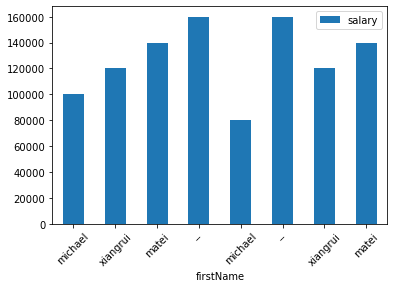

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
display()